In [1]:
#Important Note About Current File:
#This code was modified and completed based on A homework I completed myself in the Deep Learning Course taught by Professor Unberath.

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import random

import matplotlib.pyplot as plt
import time
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchsampler import ImbalancedDatasetSampler



In [2]:
file_name = "aidata.log"
X = []
Y = []
with open( file_name , "r") as file:
  for line in file:
    line = line.replace("[", "")
    line = line.replace("]", ",")
    line = line.replace("True", "1")
    line = line.replace("False", "0")
    lst = line.split(",")
    X.append(lst[:-1])
    Y.append(lst[-1].strip())
    # print(lst[-1])
X = np.array(X).astype(int)
Y = np.array(Y).astype(int)

split_ratio = 0.7
split_tr = int(np.ceil(len(X) * split_ratio))
split_t = len(X) - split_tr
train_data = []
val_data = []
train_labels = []
val_labels = []

for i in range(len(Y)):
  choice = random.random()
  if choice >= split_ratio:
    val_data.append(X[i])
    val_labels.append(Y[i])
  else:
    train_data.append(X[i])
    train_labels.append(Y[i])

train_data = np.array(train_data)
val_data = np.array(val_data)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
  

In [3]:
gpu_boole = torch.cuda.is_available()
batch_size, input_dim, hidden_1, hidden_2, hidden_3, hidden_4, hidden_5, output_dim = 32, len(X[0]), 10, 20, 80, 120, 60, 1

# np.random.rand(100)

In [4]:
# train_data, val_data = np.split(X, [split_tr])
# train_labels, val_labels = np.split(Y, [split_tr])

scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(train_data)
val_data_normalized = scaler.fit_transform(val_data)
print(train_data.shape, train_labels.shape, val_data.shape, val_labels.shape)

(152, 65) (152,) (71, 65) (71,)


In [5]:
epochs = 200
lr = 0.001

In [6]:
class assign_label(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, i):
        return (self.x[i], self.y[i])
    def __len__(self):
        return len(self.x)
    def get_labels(self):
        return self.y

In [7]:
training = assign_label(torch.FloatTensor(train_data_normalized),
                         torch.FloatTensor(train_labels))
testing = assign_label(torch.FloatTensor(val_data_normalized), torch.FloatTensor(val_labels))

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=training, sampler=ImbalancedDatasetSampler(training), batch_size = batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=testing, batch_size = batch_size, shuffle=False)

In [9]:
class Net(nn.Module):
  def __init__(self, input_size, h_1, h_2, h_3, h_4, h_5, num_classes):
    super(Net, self).__init__()

    ##feedfoward layers:
    self.ff1 = nn.Linear(input_size, h_1) #input

    self.ff2 = nn.Linear(h_1, h_2) #hidden layers

    self.ff3 = nn.Linear(h_2, h_3)
    
    self.ff4 = nn.Linear(h_3, h_4)
    
    self.ff5 = nn.Linear(h_4, h_5)
    
    self.ff_out = nn.Linear(h_5, num_classes) #logit layer     

    ##activations:
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
                
  def forward(self, input_data):
    #out = self.relu(self.ff1(input_data))
    #out = self.relu(self.ff2(out))
    out = self.sigmoid(self.ff1(input_data))
    
    out = self.sigmoid(self.ff2(out))
    out = self.sigmoid(self.ff3(out))
    out = self.sigmoid(self.ff4(out))
    out = self.sigmoid(self.ff5(out))
    
    out = self.ff_out(out)
    return out #returns class probabilities for each set of data

In [10]:
net = Net(input_size=input_dim, h_1=hidden_1, h_2=hidden_2, h_3= hidden_3, h_4 = hidden_4, h_5 = hidden_5, num_classes=output_dim)
if gpu_boole:
    net.cuda()
loss_metric = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.001, dampening = 0.000002, nesterov = False)
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.data)
torch.manual_seed(4)
weights_init(net)
net.train()

loss_batch_store = []
time_start = time.time()
training_acc_store = []
testing_acc_store = []
testing_loss_store = []
test_acc_max = 0.0
count = 0
ending_epoch = 0
for epoch in range(epochs):
    current_loss = 0
    correct = 0
    testing_acc = 0
    testing_loss = 0
    time1 = time.time()
    for i, (x, y) in enumerate(train_loader):
        
        if gpu_boole:
            x = x.cuda()
            y = y.cuda()
        optimizer.zero_grad()
        
        outputs = net.forward(x)
        loss = loss_metric(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
    for d, l in train_loader:

        if gpu_boole:
            d = d.cuda()
            l = l.cuda()
        outputs = net.forward(d)
        loss = loss_metric(outputs, l.unsqueeze(1))

        current_loss = loss.item()
        # print(loss.grad)
        rounded_train = torch.round(torch.sigmoid(outputs))
        
        correct = 100 * (((rounded_train == l.unsqueeze(1)).sum().float()) / l.size(0))
        
        
            
    for d, l in test_loader:

        if gpu_boole:
            d = d.cuda()
            l = l.cuda()
        outputs_test = net.forward(d)
        loss_test = loss_metric(outputs_test, l.unsqueeze(1))

        testing_loss = loss_test.item()
        rounded_test = torch.round(torch.sigmoid(outputs_test))
        
        testing_acc = 100 * (((rounded_test == l.unsqueeze(1)).sum().float()) / l.size(0))
        
        
    
    time2 = time.time()
    if i > 0 or epoch > 0:
            training_acc_store.append(correct.cpu().data.numpy())
    if i > 0 or epoch > 0:
            loss_batch_store.append(current_loss) 
    if i > 0 or epoch > 0:
            testing_acc_store.append(testing_acc.cpu().data.numpy())
    if i > 0 or epoch > 0:
            testing_loss_store.append(testing_loss)
    # if testing_acc > test_acc_max:
    #   test_acc_max = testing_acc
    #   count = 0
    # else:
    #   count += 1
    
    print("Epoch",epoch+1,':')
    
    print('Train accuracy: %f %%' % (correct))
    print('Train loss: %f' % (current_loss / batch_size))
    
    print('Test accuracy: %f %%' % (testing_acc))
    print('Test loss: %f' % (testing_loss / batch_size))
    
    print('Elapsed time for epoch:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')

time_end = time.time()
print ('Time elapsed:', (time_end - time_start) / 60, 'minutes')
# print("Training completed after " + str(ending_epoch) + " epochs.")    

In [12]:
net.eval()

x = torch.FloatTensor(val_data_normalized)      
y = torch.FloatTensor(val_labels)

if gpu_boole:
    x = x.cuda()
    y = y.cuda()
outputs = net.forward(x)
loss = loss_metric(outputs, y.unsqueeze(1))

current_loss = loss.item()
rounded = torch.round(torch.sigmoid(outputs))
        
correct = 100 * (((rounded == y.unsqueeze(1)).sum().float()) / y.size(0))

print('Test accuracy: %f %%' % (correct))
print('Test loss: %f' % (current_loss / batch_size))

Test accuracy: 90.140846 %
Test loss: 0.010695


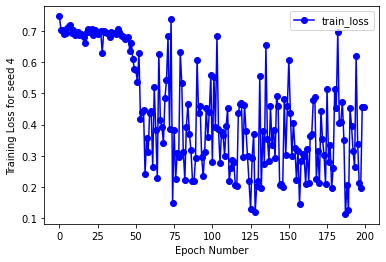

In [13]:
plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Epoch Number')
plt.ylabel('Training Loss for seed 4')
plt.legend()
plt.show()

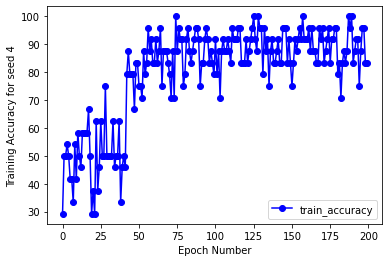

In [14]:
plt.plot(training_acc_store, '-o', label = 'train_accuracy', color = 'blue')
plt.xlabel('Epoch Number')
plt.ylabel('Training Accuracy for seed 4')
plt.legend()
plt.show()

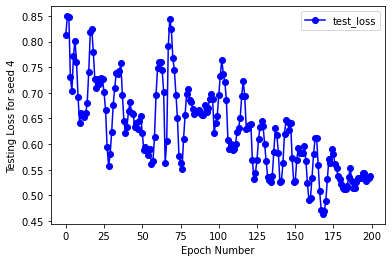

In [15]:
plt.plot(testing_loss_store, '-o', label = 'test_loss', color = 'blue')
plt.xlabel('Epoch Number')
plt.ylabel('Testing Loss for seed 4')
plt.legend()
plt.show()

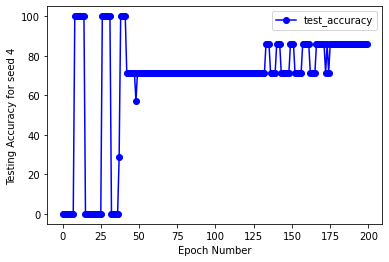

In [16]:
plt.plot(testing_acc_store, '-o', label = 'test_accuracy', color = 'blue')
plt.xlabel('Epoch Number')
plt.ylabel('Testing Accuracy for seed 4')
plt.legend()
plt.show()

In [17]:
print ('The mean for Train Accuracy: %f' % (np.mean(np.array(training_acc_store))))
print ('The mean for Train Loss: %f' % (np.mean(np.array(loss_batch_store))))
print ('The mean for Test Accuracy: %f' % (np.mean(np.array(testing_acc_store))))
print ('The mean for Test Loss: %f' % (np.mean(np.array(testing_loss_store))))

The mean for Train Accuracy: 79.562500
The mean for Train Loss: 0.446130
The mean for Test Accuracy: 68.285721
The mean for Test Loss: 0.630113


In [18]:
print ('The standard deviation for Train Accuracy: %f' % (np.std(np.array(training_acc_store))))
print ('The standard deviation for Train Loss: %f' % (np.mean(np.std(loss_batch_store))))
print ('The standard deviation for Test Accuracy: %f' % (np.std(np.array(testing_acc_store))))
print ('The standard deviation for Test Loss: %f' % (np.std(np.array(testing_loss_store))))

The standard deviation for Train Accuracy: 17.408480
The standard deviation for Train Loss: 0.181043
The standard deviation for Test Accuracy: 26.998112
The standard deviation for Test Loss: 0.084340


In [19]:
# torch.save(net.state_dict(), "linear_model")


In [20]:
false_percentage = len(np.where(Y == 0)[0]) / len(Y) * 100
print("The percentage of false in the dataset is " + str(false_percentage))

The percentage of false in the dataset is 5.381165919282512


In [ ]:
print(rounded)

In [29]:
print(np.where(val_labels==0))

(array([ 1, 12, 26, 49, 53]),)


In [39]:
pred = rounded.detach().cpu().numpy()[:, 0]
print(np.where(pred==0))

(array([12, 15, 26, 43, 60, 66]),)


In [27]:
# import csv
# with open("training_data.log", mode='a') as file:
#     writer = csv.writer(file)
#     writer.writerows(train_data)
# with open("training_labels.log", mode='a') as file:
#     writer = csv.writer(file)
#     writer.writerow(train_labels)

# with open("testing_data.log", mode='a') as file:
#     writer = csv.writer(file)
#     writer.writerows(val_data)
# with open("testing_labels.log", mode='a') as file:
#     writer = csv.writer(file)
#     writer.writerow(val_labels)

In [41]:
count_t = 0
count_f = 0
correct_t = 0
correct_f = 0

for i in range(len(pred)):
    tmp_pred = pred[i]
    tmp_tgt = val_labels[i]
    
    if tmp_tgt == 1:
        count_t += 1
        if tmp_tgt == tmp_pred:
            correct_t += 1
    else:
        count_f += 1
        if tmp_tgt == tmp_pred:
            correct_f += 1
    
print("The accuracy of True cases are: " + str(100 * (correct_t / count_t)) + "%")
print("The accuracy of False cases are: " + str(100 * (correct_f / count_f)) + "%")

The accuracy of True cases are: 93.93939393939394%
The accuracy of False cases are: 40.0%
